# Warehouse location and transport
[![warehouse_location.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/supply_chain/warehouse_location.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/supply_chain/warehouse_location.ipynb) [![Open In Deepnote](https://deepnote.com/buttons/launch-in-deepnote-small.svg)](https://deepnote.com/launch?url=https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/supply_chain/warehouse_location.ipynb) [![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/supply_chain/warehouse_location.ipynb) [![Open In Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/supply_chain/warehouse_location.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/supply_chain/warehouse_location.ipynb) [![Powered by AMPL](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/supply_chain/warehouse_location.ipynb)](https://ampl.com)

Description: Model for warehouse allocation. Farms (suppliers) send feedstock to warehouses, and later on, those warehouses send it to a production plant. The problem involves modeling a storage facility location problem with a transportation component to the final plant.

The problem is a MILP one solved with Ampl + Highs.

Tags: facility location, highs, mip, mixed-integer-linear, supply_chain, network, transportation, graphs, networkx, transportation, mp

Notebook author: Marcos Dominguez Velad <<marcos@ampl.com>>

Model author: Marcos Dominguez Velad <<marcos@ampl.com>>

In [1]:
# Install dependencies
%pip install -q amplpy matplotlib networkx

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Problem

Feedstock needs to be sent from farms (suppliers) to storage facilities, and from there to a processing plant (the only consumer). Given the demand for the processing plant, decide which storage centers to use in order to store and later transport the feedstock so that transportation costs get minimized.

Variants of this problem are fundamental in supply chain industry. The idea of this notebook is to showcase how to solve the problem in a simple way through a simple Mathematical formulation, and visualize the solution via networkx in Python.

## Formulation

### Facility Location Problem

**Sets:**
- $S$: Set of potential facility locations.
- $F$: Set of demand points.

**Parameters:**
- $d_{fs}$: Distance from farm $f$ to storage center $s$.
- $d_{sp}$: Distance from storage center $s$ to plant.
- $c_{\text{transport}}$: Cost of transportation per unit.
- $c_{\text{open}}$: Cost of using a storage center.
- $F_f$: Capacity of farm $f$.
- $D_p$: Demand at plant $p$.

**Decision Variables:**
- $y_s$: Binary decision variable; 1 if a facility is placed at location $s$, 0 otherwise.
- $x_{fs}$: Amount of shipment from farm $f$ to facility $s$. This is constrained by the capacity $F_f$ of farm $f$.
- $x_{sp}$: Amount of shipment from facility $s$ to the plant. This is constrained by the demand $D_p$ at the plant.

**Objective Function:**
Minimize the total transportation cost:

$$
\text{Minimize } \text{Total_cost} = \sum_{f \in F, s \in S} d_{fs} \cdot x_{fs} \cdot c_{\text{transport}} + \sum_{s \in S} d_{sp} \cdot x_{sp} \cdot c_{\text{transport}}
$$

**Constraints:**

1. **Facility Constraint:**
   Ensure at least one facility is chosen:

   $$
   \sum_{s \in S} y_s \geq 1
   $$

2. **Capacity Constraint:**
   The total shipment from a farm $f$ to all facilities $s$ must not exceed the farm's capacity:

   $$
   \sum_{s \in S} x_{fs} \leq F_f \quad \forall f \in F
   $$

3. **Demand Satisfaction:**
   The total shipment from all facilities $s$ to the plant must meet the plant's demand:

   $$
   \sum_{s \in S} x_{sp} \geq D_p
   $$

4. **Balance equation:**
   Ensure flow conservation at each storage center $s$, where the input equals the output:

   $$
   \sum_{f \in F} x_{fs} = x_{sp} \quad \forall s \in S
   $$

5. **Linking constraints**
   - If no facility is placed at location $s$, then no shipment should occur from any farm $f$ to that location:

     $$
     y_s = 0 \Rightarrow x_{fs} = 0 \quad \forall f \in F, \forall s \in S
     $$

   - Similarly, if no facility is placed at location $s$, then no shipment should occur from that location to the plant:

     $$
     y_s = 0 \Rightarrow x_{sp} = 0 \quad \forall s \in S
     $$

Notice that these are "indicator constraints" that may be linearized, but Ampl handles them automatically so Highs solver (a MIP solver) can deal with them. Read more about automatic reformulations and advanced modeling features in

https://mp.ampl.com/model-guide.html

In [3]:
%%writefile storage_center_location.mod
reset;
# Sets
set S;  # Set of potential facility locations
set F;  # Set of demand points

# Parameters
# distances
param d_fs{F,S}; #distance from farm to storage center
param d_sp{S}; #distance from storage center to plant
param c_transport; # cost of transportation (per unit)
param c_open; # cost of using a storage center

param F_f{F}; # Capacity of farm f
param D_p; # Demand at plant p

# Decision Variables
var y{s in S} binary;  # Binary decision variable whether a facility is placed at location s
var x_fs{f in F, s in S} >= 0 <= F_f[f];  # Shipment from facility s to demand point f
var x_sp{s in S} >= 0 <= D_p;  # Shipment from the supply point to facility s

# Objective Function
minimize Total_cost:
    sum {f in F, s in S} d_fs[f,s] * x_fs[f,s] * c_transport +
    sum {s in S} d_sp[s] * x_sp[s] * c_transport +
    sum {s in S} y[s] * c_open;

# Constraints

# Ensure at least one facility is chosen
subject to Facility_Constraint:
    sum {s in S} y[s] >= 1;

# Farm supply constraint
subject to Capacity_Constraint {f in F}:
    sum {s in S} x_fs[f,s] <= F_f[f];

# Demand satisfaction
subject to Demand_Constraint:
    sum {s in S} x_sp[s] >= D_p;

# Flow conservation at storage centers, input = output
subject to Flow_Conservation {s in S}:
    sum {f in F} x_fs[f,s] = x_sp[s];

# Logical linking between flow and opened storage
subject to Flow_Limit_fs {f in F, s in S}:
    y[s] == 0 ==> x_fs[f,s] == 0;

subject to Flow_Limit_sp {s in S}:
    y[s] == 0 ==> x_sp[s] == 0;

Overwriting storage_center_location.mod


## Load the data

In [4]:
# Define our data
# Sets
F = ["F" + str(i) for i in range(1, 5)]
S = ["S" + str(i) for i in range(1, 11)]

from random import randint


def generate_coordinates(F, S, minX=-50, maxX=50, minY=-50, maxY=50):
    # Generate random coordinates for the nodes
    coordinates_F = {}
    coordinates_S = {}
    for f in F:
        coordinates_F[f] = (randint(minX, maxX), randint(minY, maxY))
    for s in S:
        coordinates_S[s] = (randint(minX, maxX), randint(minY, maxY))
    coordinates_Plant = (randint(minX, maxX), randint(minY, maxY))
    return coordinates_F, coordinates_S, coordinates_Plant


coordinates_F, coordinates_S, coordinates_Plant = generate_coordinates(F, S)


def dist(x, y):
    return ((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2) ** 0.5


# Parameters

d_fs = {(f, s): dist(coordinates_F[f], coordinates_S[s]) for f in F for s in S}
d_sp = {s: dist(coordinates_S[s], coordinates_Plant) for s in S}
c_transport = 3
c_open = 1000
F_f = {f: 100 for f in F}
D_p = 300

# Load data into AMPL
# First read the model
ampl.read("storage_center_location.mod")
# Then load the data into the model entities

# Sets
ampl.set["F"] = F
ampl.set["S"] = S

# Parameters
ampl.param["d_fs"] = d_fs
ampl.param["d_sp"] = d_sp
ampl.param["c_transport"] = c_transport
ampl.param["c_open"] = c_open
ampl.param["F_f"] = F_f
ampl.param["D_p"] = D_p

## Solve and process the solution

In [5]:
# Solve the model
ampl.solve(solver="highs")
assert ampl.solve_result == "solved", ampl.solve_result

# Get results
y_values = ampl.getVariable("y").getValues().to_dict()
x_fs_values = ampl.getVariable("x_fs").getValues().to_dict()
x_sp_values = ampl.getVariable("x_sp").getValues().to_dict()

# Display results
print("Facility location decision y(s):")
print(y_values)

print("Shipment from facilities to demand points x_fs(f,s):")
print(x_fs_values)

print("Shipment from supply point to facilities x_sp(s):")
print(x_sp_values)

HiGHS 1.10.0: HiGHS 1.10.0: optimal solution; objective 59698.70705
9 simplex iterations
1 branching nodes
Facility location decision y(s):
{'S1': 0, 'S10': 0, 'S2': 0, 'S3': 1, 'S4': 0, 'S5': 0, 'S6': 0, 'S7': 0, 'S8': 0, 'S9': 0}
Shipment from facilities to demand points x_fs(f,s):
{('F1', 'S1'): 0, ('F1', 'S10'): 0, ('F1', 'S2'): 0, ('F1', 'S3'): 0, ('F1', 'S4'): 0, ('F1', 'S5'): 0, ('F1', 'S6'): 0, ('F1', 'S7'): 0, ('F1', 'S8'): 0, ('F1', 'S9'): 0, ('F2', 'S1'): 0, ('F2', 'S10'): 0, ('F2', 'S2'): 0, ('F2', 'S3'): 100, ('F2', 'S4'): 0, ('F2', 'S5'): 0, ('F2', 'S6'): 0, ('F2', 'S7'): 0, ('F2', 'S8'): 0, ('F2', 'S9'): 0, ('F3', 'S1'): 0, ('F3', 'S10'): 0, ('F3', 'S2'): 0, ('F3', 'S3'): 100, ('F3', 'S4'): 0, ('F3', 'S5'): 0, ('F3', 'S6'): 0, ('F3', 'S7'): 0, ('F3', 'S8'): 0, ('F3', 'S9'): 0, ('F4', 'S1'): 0, ('F4', 'S10'): 0, ('F4', 'S2'): 0, ('F4', 'S3'): 100, ('F4', 'S4'): 0, ('F4', 'S5'): 0, ('F4', 'S6'): 0, ('F4', 'S7'): 0, ('F4', 'S8'): 0, ('F4', 'S9'): 0}
Shipment f

## Visualize the solution

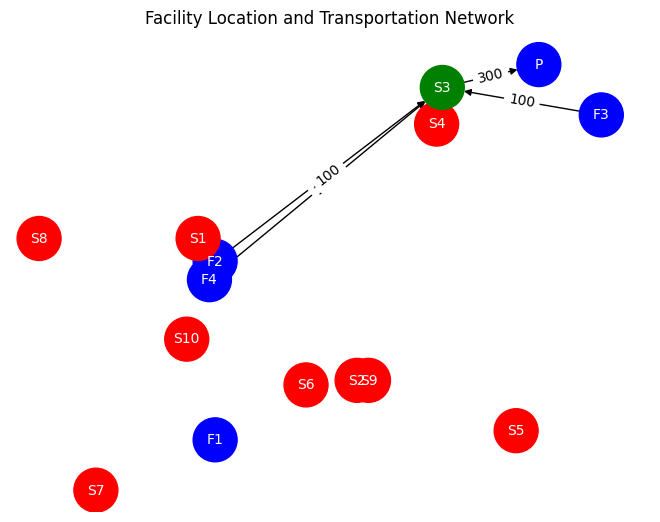

In [6]:
import networkx as nx
import matplotlib.pyplot as plt


def generate_network(
    y_values, x_fs_values, x_sp_values, coordinates_F, coordinates_S, coordinates_Plant
):
    # Create a directed graph
    G = nx.DiGraph()

    # Add the farms (F) as nodes in blue
    farms = set([f for f, s in x_fs_values.keys()])
    G.add_nodes_from(farms, color="blue", label="Farm")

    # Add the storage centers (S) as nodes
    storage_centers = set([s for f, s in x_fs_values.keys()])
    for s in storage_centers:
        color = "green" if y_values[s] == 1 else "red"
        G.add_node(s, color=color, label="Storage Center")

    # Add the processing plant (P) as an extra node in blue
    G.add_node("P", color="blue", label="Processing Plant")

    # Add edges from farms to storage centers with the flow values
    for (f, s), flow_value in x_fs_values.items():
        if flow_value > 0:
            G.add_edge(f, s, weight=flow_value)

    # Add edges from storage centers to the processing plant with the flow values
    for s, flow_value in x_sp_values.items():
        if flow_value > 0:
            G.add_edge(s, "P", weight=flow_value)

    # Define the positions using the provided coordinates
    pos = {}

    # Add positions for farms
    for farm, coord in coordinates_F.items():
        pos[farm] = coord

    # Add positions for storage centers
    for storage, coord in coordinates_S.items():
        pos[storage] = coord

    # Add position for the processing plant
    pos["P"] = coordinates_Plant

    # Extract node colors
    colors = [G.nodes[node]["color"] for node in G.nodes]
    labels = {node: node for node in G.nodes}
    edge_labels = nx.get_edge_attributes(G, "weight")

    # Draw the graph with provided coordinates
    nx.draw(
        G,
        pos,
        node_color=colors,
        with_labels=True,
        labels=labels,
        node_size=1000,
        font_size=10,
        font_color="white",
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="black")

    plt.title("Facility Location and Transportation Network")
    plt.show()


# Example usage with your retrieved data
generate_network(
    y_values, x_fs_values, x_sp_values, coordinates_F, coordinates_S, coordinates_Plant
)

[AMPL Website](https://ampl.com) | [AMPL Colab](https://colab.ampl.com) | [Community Edition]( https://ampl.com/ce/) | [Twitter](https://twitter.com/AMPLopt) | [LinkedIn](https://www.linkedin.com/company/ampl)